In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

C:\Users\jdiaz\.conda\envs\fast_infl_funct\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Use some real data - Jiang et al

In [2]:
x = torch.from_numpy(
    np.load("../../../hydro-interpretive-dl/jiang_et_al_xtrain.npy")
).float()
y = torch.from_numpy(
    np.load("../../../hydro-interpretive-dl/jiang_et_al_ytrain.npy")
).float()
print(x.shape)

# Just use the first 100 examples of 180-day sequences
x = x[:100]
y = y[:100]

x.shape, y.shape

torch.Size([13872, 180, 2])


(torch.Size([100, 180, 2]), torch.Size([100, 1]))

# Define a simple model

In [3]:
class LSTM(torch.nn.Module):
    
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = torch.nn.LSTM(x.shape[2], 16, batch_first = True)
        self.fc = torch.nn.Linear(16, 1)
        
    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = x[:, -1, :] # only use the last output of the lstm
        x = self.fc(x)
        return(x)

# Make it
np.random.seed(123)
torch.manual_seed(123)
model = LSTM()

In [4]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             weight_decay= 0.00001) # training with weight decay should help convexity

Wall time: 49.3 s


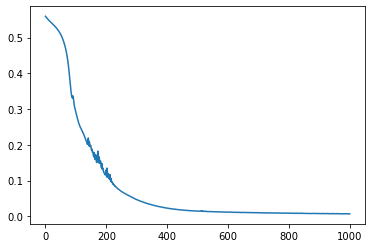

In [5]:
%%time
loss_ls = []
for i in range(1000):
    out = model(x)
    loss = loss_fn(out, y)
    optimizer.zero_grad()
    loss.backward()
    loss_ls.append(loss.item())
    optimizer.step()
plt.plot(loss_ls)

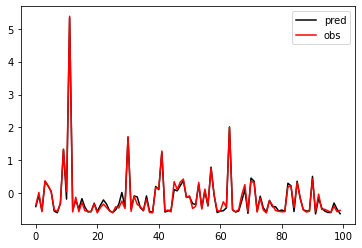

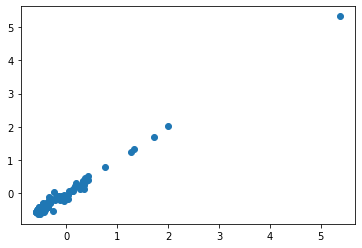

In [6]:
plt.plot(out.detach(), color = 'black', label = 'pred')
plt.plot(y, color = 'red', label = 'obs')
plt.legend()

plt.pause(0.001)
plt.scatter(y, out.detach());

# data loaders

In [7]:
x = torch.from_numpy(
    np.load("../../../hydro-interpretive-dl/jiang_et_al_xtrain.npy")
).float()
y = torch.from_numpy(
    np.load("../../../hydro-interpretive-dl/jiang_et_al_ytrain.npy")
).float()

x_train = x[:100]
y_train = y[:100]

x_test = x[-100:]
y_test = y[-100:]

In [8]:
# Put together dataloaders
train_data = []
for i in range(len(x_train)):
    train_data.append([x_train[i], y_train[i]])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False, pin_memory=True)

In [9]:
# Put together dataloaders
test_data = []
for i in range(len(x_test)):
    test_data.append([x_test[i], y_test[i]])

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True, pin_memory=True)

# fast influence functions

In [10]:
import sys
sys.path.insert(0, '../../../fast-influence-functions/')

In [11]:
import influence_utils.nn_influence_utils as fif

In [12]:
influences, train_inputs_collections, s_test = fif.compute_influences(0,
                                                                      'cpu',
                                                                      model,
                                                                      [x_test[[46]],
                                                                       y_test[[46]]],
                                                                      train_loader,
                                                                      train_loader,
                                                                      s_test_num_samples = 100)

9473.49 | 77.93: 100%|██████████| 100/100 [00:07<00:00, 12.92it/s]   
100%|██████████| 100/100 [00:02<00:00, 35.71it/s]


In [13]:
influences2, train_inputs_collections2, s_test2 = fif.compute_influences(0,
                                                                      'cpu',
                                                                      model,
                                                                      [x_test[[46]],
                                                                       y_test[[46]]],
                                                                      train_loader,
                                                                      train_loader,
                                                                      s_test_num_samples = 100)

9473.49 | 77.93: 100%|██████████| 100/100 [00:07<00:00, 13.08it/s]   
100%|██████████| 100/100 [00:02<00:00, 36.11it/s]


In [14]:
influences3, train_inputs_collections3, s_test3 = fif.compute_influences(0,
                                                                      'cpu',
                                                                      model,
                                                                      [x_test[[46]],
                                                                       y_test[[46]]],
                                                                      train_loader,
                                                                      train_loader,
                                                                      s_test_num_samples = 100)

9473.49 | 77.93: 100%|██████████| 100/100 [00:07<00:00, 12.89it/s]   
100%|██████████| 100/100 [00:02<00:00, 36.05it/s]


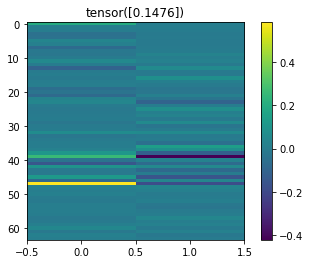

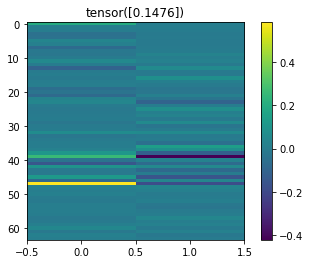

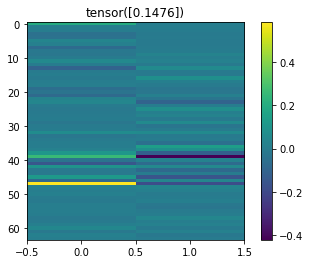

In [15]:
# s-test is highly converged between runs
plt.imshow(s_test[0], aspect = 1/32)
plt.title(s_test[-1])
plt.colorbar()
plt.pause(0.001)

plt.imshow(s_test2[0], aspect = 1/32)
plt.title(s_test2[-1])
plt.colorbar()
plt.pause(0.001)

plt.imshow(s_test3[0], aspect = 1/32)
plt.title(s_test3[-1])
plt.colorbar();

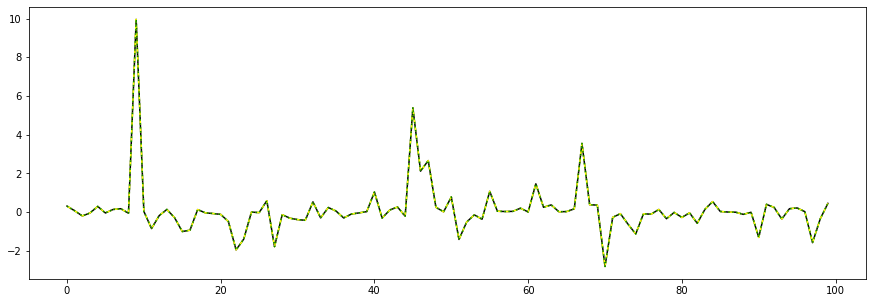

In [16]:
# influence calculcations are too
plt.figure(figsize = (15, 5))
plt.plot(np.asarray(list(influences.values())), linestyle = '-', color = 'black')
plt.plot(np.asarray(list(influences2.values())), linestyle = '--', color = 'yellow')
plt.plot(np.asarray(list(influences3.values())), linestyle = ':', color = 'green');

# Leave-one-out across whole training set

In [17]:
raise ImportError

# RAN ON TALLGRASS GPU INSTANCE
x_test = x_test.cuda()

preds = []

for ref_i in range(100):
    print(ref_i)
    x_train_alt = torch.from_numpy(np.concatenate(
        [x_train[:ref_i], x_train[ref_i+1:]]
    )).float().cuda()
    y_train_alt = torch.from_numpy(np.concatenate(
        [y_train[:ref_i], y_train[ref_i+1:]]
    )).float().cuda()
    
    np.random.seed(123)
    torch.manual_seed(123)
    model = LSTM().cuda()
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), weight_decay = 0.00001)

    for i in range(1000): 
        out = model(x_train_alt)
        loss = loss_fn(out, y_train_alt)
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

    preds.append(model(x_test).detach().cpu().numpy())
    
np.save('leave_one_out_preds_L2_0.00001.npy', np.asarray(preds)[:, :, 0]) # filepath specifies L2 value if applicable

ImportError: 

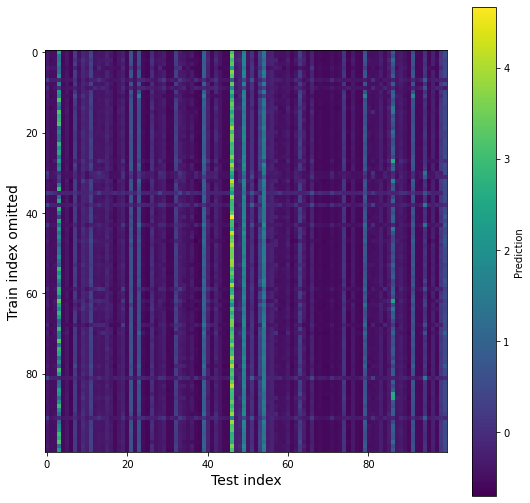

In [18]:
leave_out_out_preds = np.load('leave_one_out_preds_L2_0.00001.npy')

plt.figure(figsize = (9, 9))
plt.imshow(leave_out_out_preds)
plt.xlabel('Test index', fontsize = 14)
plt.ylabel('Train index omitted', fontsize = 14)
plt.colorbar(label = 'Prediction');

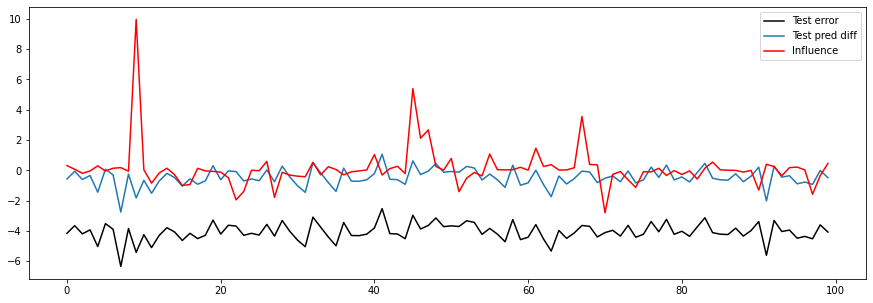

In [19]:
plt.figure(figsize = (15, 5))
plt.plot(leave_out_out_preds[:, 46] - y_test[46].item(), color = 'black', label = 'Test error')
plt.plot(leave_out_out_preds[:, 46] - model(x_test)[46].item(), label = 'Test pred diff')
plt.plot(np.asarray(list(influences.values())), color = 'red', label = 'Influence')
plt.legend();

SpearmanrResult(correlation=0.01356135613561356, pvalue=0.8934700217248288)

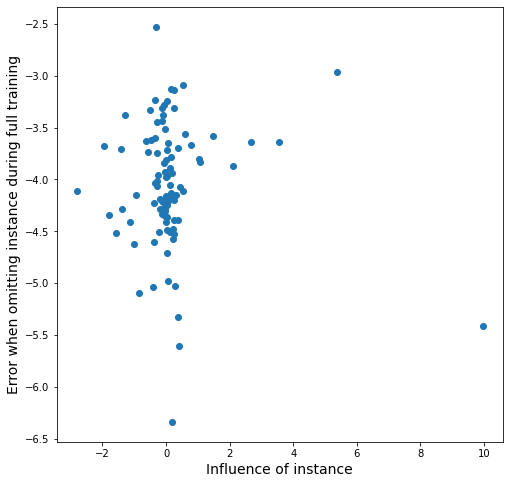

In [20]:
from scipy.stats import spearmanr

errors = leave_out_out_preds[:, 46] - y_test[46].item()
influences_clean = np.asarray(list(influences.values()))

plt.figure(figsize = (8, 8))
plt.scatter(influences_clean,
            errors)
plt.ylabel('Error when omitting instance during full training', fontsize = 14)
plt.xlabel('Influence of instance', fontsize = 14)
spearmanr(influences_clean, errors)

# Current state of this work

Unable to get useful influence answers, so this work is being sat aside until there are new, promising directions or tips. If we can not get useful/trustworthy influence answers when working on this small, verifiable experiment, then we should avoid them in any real/substantial tasks. Also, see the "fragile" reference.

# Documented resources

Listed dates are mostly based on latest arxiv version...

### Primary references 

* Main reference
  * https://arxiv.org/abs/1703.04730 (Koh and Liang et al. 2020)
* Faster extension with public pytorch code
  * https://arxiv.org/abs/2012.15781 (Guo et al. 2021)
* A critiquing experiment study, "INFLUENCE FUNCTIONS IN DEEP LEARNING ARE FRAGILE"
  * https://arxiv.org/abs/2006.14651 (Basu et al. 2021)
  
### Tangential references

* A more thorough usage of influence functions (combined with input importance; what parts of what training instances are influential?)
  * https://arxiv.org/abs/2010.06943 (Meng et al. 2020)
* An information theory approach for the same/similar goal?
  * https://arxiv.org/abs/2101.06640 (Harutyunyan et al. 2021)
* An efficient/dropout approach for the same/similar goal?
  * DOI: 10.18653/v1/2020.sustainlp-1.6 (Kobayashi et al. 2020)
